
# project 3: Analyze A/B Test Results 
 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion ](#conclusion )



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  we goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now,we read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
# Load your data and print out a few lines.
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
# this returns a tuple of the dimensions of the dataframe
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [5]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
sum((df.landing_page != 'new_page') & (df.group == 'treatment'))

1965

**f.** Do any of the rows have missing values?

In [8]:
# number of nulls in each column
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

We will figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now create a new dataset that meets the specifications. Store your new dataframe in **df2**.

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
treatment_df = df[(df['group'] == 'treatment') & (df['landing_page'] == 'new_page')] 
control_df = df[(df['group'] == 'control') & (df['landing_page'] == 'old_page')] 
df2 = treatment_df.append(control_df)
df2

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1
10,929503,2017-01-18 05:37:11.527370,treatment,new_page,0
11,834487,2017-01-21 22:37:47.774891,treatment,new_page,0
12,803683,2017-01-09 06:05:16.222706,treatment,new_page,0
13,944475,2017-01-22 01:31:09.573836,treatment,new_page,0
14,718956,2017-01-22 11:45:11.327945,treatment,new_page,0


In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  

**a.** How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
sum(df2['user_id'].duplicated())

1

In [13]:
df2['user_id'][df2['user_id'].duplicated(keep=False)]

1899    773192
2893    773192
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [14]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [15]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2['user_id'].drop_duplicates(inplace=True)
df2 = df2.drop([2893])
# Check again if the row with a duplicate user_id is deleted or not
sum(df2['user_id'].duplicated())

0

### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

> The probability  we'll compute represents the overall "converted" success rate in the population and we may call it $p_{population}$.



In [16]:
#The probability we'll compute represents the overall "converted" success rate in the population.
population = df2['converted'].mean()
population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_control = (df2.query('group == "control"')['converted'] == 1).mean()
p_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_treatment = (df2.query('group == "treatment"')['converted'] == 1).mean()
p_treatment

0.11880806551510564

> The probabilities we've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. we will need that later.  

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
# Compute observed difference in converted rates
obs_diff = p_treatment - p_control

# Display observed difference in converted rates
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [20]:
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

- Probability of converting regardless of page (0.1196).
- Given that an individual was in the control group, the probability of converting (0.1204).
- Given that an individual was in the treatment group, the probability of converting (0.1188).
- The probability of receiving the new page (0.5001).
- The new treatment group users no lead to more conversions.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.


$$H_0: p_{new} <= p_{old} $$

$$H_1: p_{new} > p_{old} $$  

**$p_{new}$ and $p_{old}$ are the converted probability  mean values for new page and old page , respectivley.**

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new = (df2.query('group == "treatment"')['landing_page'] == 'new_page').count()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = (df2.query('group == "control"')['landing_page'] == 'old_page').count()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.<br> Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.

In [25]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1] ,n_new,p_new)
new_page_converted

array([1, 0, 1, ..., 0, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1],n_old,p_old)
old_page_converted

array([0, 1, 0, ..., 0, 1, 1])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
new_page_converted.mean()

0.5022641249741931

In [28]:
old_page_converted.mean()

0.49842366837837465

In [29]:
new_page_converted.mean() - old_page_converted.mean()

0.0038404565958184977


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [30]:
# Sampling distribution     
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
# convert to numpy array    
p_diffs = np.array(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected? <br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


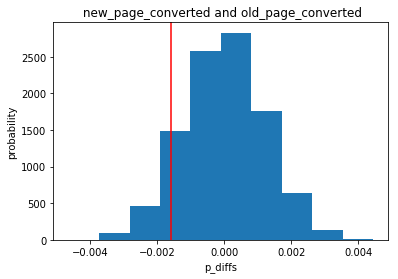

In [31]:
plt.title(' new_page_converted and old_page_converted')
plt.xlabel('p_diffs')
plt.ylabel('probability')
plt.hist(p_diffs);
# plot line for observed statistic
plt.axvline(obs_diff, c='red');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [36]:
# compute p value
(p_diffs > obs_diff).mean()

0.9043

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 


- Based on the p-value retrieved using the sample and any reasonable type I error rate (5%),
new pages (0.1189)
old pages (0.1203)
- We have statistically significant evidence to suggest the difference between the new and old pages mean is different from 0.00147.(null hypothesis.)





**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [37]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old =df2.query("landing_page == 'old_page' and converted == 1").shape[0] 

# number of conversions with the new_page
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]

# number of individuals who were shown the old_page
n_old = (df2.query('group == "control"')['landing_page'] == 'old_page').shape[0]

# number of individuals who received new_page
n_new = (df2.query('group == "treatment"')['landing_page'] == 'new_page').shape[0]

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---



In [38]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new] ,[n_old, n_new] ,alternative =  "smaller")
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


- The z-score and p-value computations from the test statistic suggest that findings fail to reject the null hypothesis.
- The p-values are equal 0.905, when calculated as not computing ‘the alternative’. They agree with the findings in the previous part.
- Because the z_score is found less than z_alpha=1.64 for a confidence interval of 95%, we fail to reject the null.


<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

- The type of regression should we be performing, in this case, is logistic regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [39]:
#dummy variables
df2[['no_ab_page', 'ab_page']]= pd.get_dummies(df2['landing_page'])
df2=df2.drop('no_ab_page', axis=1)

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [40]:
import statsmodels.api as sm

#instantiate logistic regression model
df2['intercept']= 1
logit_mod =sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])

#fit the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
#get summary statistics
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-10-23 20:26 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0038    0.0081  -247.1457  0.0000  -2.0197  -1.9879
ab_page       0.0150    0.0114     1.3109  0.1899  -0.0074   0.0374
==================================================================

"""

In [42]:
np.exp(0.0150) #to exponentiate

1.015113064615719

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


 - The p-value for both of them is 0.1899 when two-tailed tested without specifying the alternative.
 - Conversion is 1.015 times more likely to convert the page as likely holding all else constant.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?


- The a factor could be  important and critical to affecting the result. In such a case, believe that adding the factor improves the model. 
- A common problem of adding many parameters into the regression model is multicollinearity. Multicollinearity occurs when two or more parameters are collinear with each other.


**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. We will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


 Provide the statistical output as well as a written response to answer this question.

In [43]:
# Read the countries.csv
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
# Join with the df2 dataframe
df2 = df2.merge(countries_df )
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,0,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,0,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,0,1,CA


In [45]:
# Create the necessary dummy variables
df2[['UK', 'US', 'CA']]= pd.get_dummies(df2['country'])
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US,CA
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,US,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,US,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,0,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,0,1,UK,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,0,1,CA,1,0,0


In [46]:
# Fit your model, and summarize the results
#instantiate logistic regression model
df2['intercept']= 1
logit_mod =sm.Logit(df2['converted'],df2[['intercept','ab_page', 'US', 'CA']])

#fit the model
results = logit_mod.fit()

#get summary statistics
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-10-23 20:26 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0450    0.0266  -76.8197  0.0000  -2.0971  -1.9928
ab_page        0.0149    0.0114    1.3069  0.1912  -0.0075   0.0374
US             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
CA             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

- The p-values indicate that there is no country impact on conversion.

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [47]:
#the effect of page and country to predict the conversion.

df2['ab_UK'] = df2['ab_page'] * df2['UK']
df2['ab_US'] = df2['ab_page'] * df2['US']
df2['ab_CA'] = df2['ab_page'] * df2['CA']

In [48]:
# Fit your model, and summarize the results
#instantiate logistic regression model
df2['intercept']= 1
logit_mod =sm.Logit(df2['converted'],df2[["intercept", "ab_page", "UK", "CA", "ab_UK", "ab_CA"]])

#fit the model
results = logit_mod.fit()

#get summary statistics
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-10-23 20:26 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9814    0.0161  -122.8600  0.0000  -2.0130  -1.9498
ab_page      -0.0108    0.0228    -0.4749  0.6349  -0.0555   0.0339
UK           -0.0901    0.0405    -2.2252  0.0261  -0.1694  -0.0107
CA           -0.0257    0.0188    -1.3634  0.1728  -0.0625   0.0112
ab_UK         0.0783    0.0568     1.3783  0.1681  -0.0330   0.1896
ab_CA         0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

In [49]:
np.exp(0.0783) , np.exp(0.0314)#to exponentiate

(1.0814470441230692, 1.0318981806179213)


 - The p-values indicate that there is no country impact on conversion.
 - Their impacts are small. the results are not reliable enough to talk about a significant effect on conversion based on the individual factors of country and page.
 - Conversion US is 1.081  times more likely to convert the page as likely holding all else constant.
 - Conversion CA is 1.031  times more likely to convert the page as likely holding all else constant.



### Conclusion 
- The conclusion was made from this analysis we  fail to reject the null hypothesis.
- The recommendation would we make to the company we Keep the old webpage.